In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### The purpose of this test is to create a robust search model, that takes as an input summarized texts (headlines), and outputs a ranking of texts that correspond to the input.

### In order to solve this problem, I chose to proceed in two different ways:



## **Embedding of texts without topic modeling (LDA)** 


 I will follow the following steps:


1.   Creation of a preprocessing and embedding pipeline
2.   Vectorization of all the texts in our data base (using the embedding)
3.   choice of a similarity function (fast cosine similarity)

## **Embedding of texts with topic modeling (LDA)**

In this case, in addition to the steps mentioned previously, I will add a topic modeling step just before the computation of similarities between the input and the texts.
The purpose of LDA (latent Dirichlet allocation) is to exctract **semantic features** from the documents, and build similarities based on these semantic features, and not on overlapping words between texts.

### *N.B:*  
*   I will not need to split the texts database into test and training sets, as there will be no training (we will only compute the vectors of embedding of the texts)
*   The metric that I used to evaluate the search model is recall@k, for k=1, 10 then 30.
### **performances**:
#### I obtained the following recall@k report:
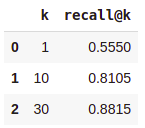






#### Let's start by downloading the word2vec embedding file.

#### I didn't want to use TFIDF for the embedding because I think that it doesn't deal with new words (words that aren't in the texts database). While word2vec has a large vocabulary. The second reason is that word2vec is trained to learn semantic similarities between words, unlike TFIDF

In [2]:
!pip install wget

!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=7cec3d0eb7bc65da55bd666f2bd13d52227c759832ffac9b5cf266e8c6f5e20b
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
--2021-03-17 18:20:03--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.106.118
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.106.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  16.1MB/s    in 99s     

2021-03-17 18:21:42 (15.9 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



#### Here we install and import relevant libraries

In [3]:
!pip install adjustText

  Created wheel for adjustText: filename=adjustText-0.7.3-cp37-none-any.whl size=7100 sha256=fa9d059c958256f2c32f60745bfcf9f8a80e4f2b4b9a083c90ad1f4657b58f29
  Stored in directory: /root/.cache/pip/wheels/41/95/74/7d347e136d672f8bc28e937032bc92baf4f80856763a7e7b72
Successfully built adjustText


In [5]:
import pandas as pd
import nltk
import gensim
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
from gensim import corpora, models
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer


from adjustText import adjust_text
from sklearn.metrics.pairwise import cosine_similarity
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/news_summary_more.csv')

#### Our data set is composed of two columns: 


1.   Headlines: which contains summarized texts
2.   Texts: Which contains texts

The idea of the project is to build a model that takes as an input Headlines (or any other short text), and gives a ranking of relevant texts that are associated to the input.



In [7]:
data.head(5)

headlines                                               text
0  upGrad learner switches to career in ML & Al w...  Saurav Kant, an alumnus of upGrad and IIIT-B's...
1  Delhi techie wins free food from Swiggy for on...  Kunal Shah's credit card bill payment platform...
2  New Zealand end Rohit Sharma-led India's 12-ma...  New Zealand defeated India by 8 wickets in the...
3  Aegon life iTerm insurance plan helps customer...  With Aegon Life iTerm Insurance plan, customer...
4  Have known Hirani for yrs, what if MeToo claim...  Speaking about the sexual harassment allegatio...

In [6]:
print("we have a data set of " + str(len(data)) + " text")

we have a data set of 98401 text


### First, I wanted to understand a little bit the data set. For that, I tokenized the texts, transformed the words into vectors, reduced the dimension t-SNE, and visualized them on a plot (in order to demonstrate the relevancy of the embedding)

In [6]:
def tokenize_base(data):
  texts = data['text']
  texts_list = [title for title in texts]
  big_title_string = ' '.join(texts_list)
  tokens = word_tokenize(big_title_string)
  # Remove non-alphabetic tokens, such as punctuatio
  words = [word.lower() for word in tokens if word.isalpha()]
  # Filter out stopwords
  stop_words = set(stopwords.words('english'))
  words = [word for word in words if not word in stop_words]
  return(words)

In [12]:
# Load word2vec model (trained on an enormous Google corpus)
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz' # from above

model = gensim.models.KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary = True) 

# Check dimension of word vectors
model.vector_size

300

In [11]:
# Filter the list of vectors to include only those that Word2Vec has a vector for
words = tokenize_base(data)

def word_vec(words):

  vector_list = [model[word] for word in words if word in model.vocab]

  # Create a list of the words corresponding to these vectors
  words_filtered = [word for word in words if word in model.vocab]

  # Zip the words together with their vector representations
  word_vec_zip = zip(words_filtered, vector_list)

  # Cast to a dict so we can turn it into a DataFrame
  word_vec_dict = dict(word_vec_zip)
  return(word_vec_dict)


#### Let's pick three words from our tokenization base and see the vectors representing these words

In [10]:
word_vec_dict = word_vec(words)
df = pd.DataFrame.from_dict(word_vec_dict, orient='index')
df.head(3)

0         1         2    ...       297       298       299
kant     0.032227  0.018311  0.134766  ... -0.054199 -0.004639  0.195312
alumnus  0.156250  0.096191  0.050049  ... -0.103027  0.004547  0.033936
pg      -0.059082  0.137695 -0.098145  ...  0.127930 -0.077637  0.394531

[3 rows x 300 columns]

#### Here comes the dimensionality reduction step

In [13]:
from sklearn.manifold import TSNE

# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(df[:400])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


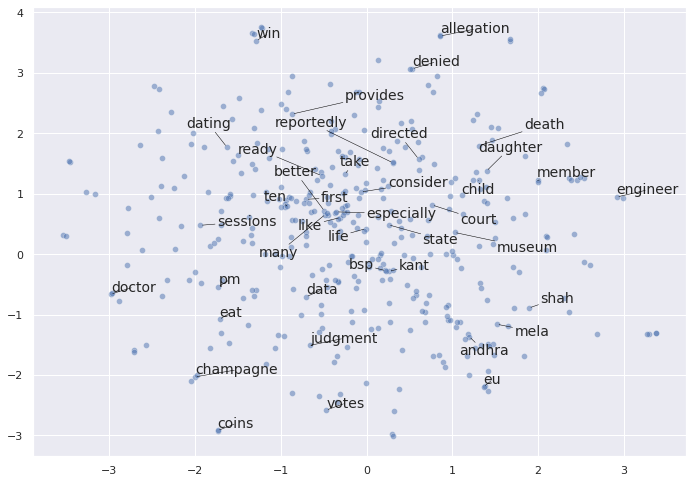

In [14]:


sns.set()
# Initialize figure
fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

# Import adjustText, initialize list of texts
texts = []
words_to_plot = list(np.arange(0, 400, 10))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], df.index[word], fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

### Now that we've seen the interest of using word2vec embedding (instead of TFIDF for instance), let's convert our documents into vectors

In [13]:
stop_words = set(stopwords.words('english'))

def document_vector( text):
    doc = text
    doc = doc.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    #we only keeps numeric and alphabetic caracters
    doc = [word for word in doc if word.isalpha() or word.isnumeric()] 
    doc = [word for word in doc if word in model.vocab]
    #return the average of the embeddings of all the words contained in the text (if these words are in the word2vec model dict)
    return(np.mean(model[doc], axis=0))

### Let's transform all the texts (the column text of our dataframe) into vectors using the previous function.

### Using these vectors we can compute the similarity of texts with summarized headlines (inputs)

In [56]:
vectors_of_texts = list(map(document_vector, data['text'].values))

### In order to compute the similarity between two texts, we can use the cosine similarity metric between the embeddings of the two texts.

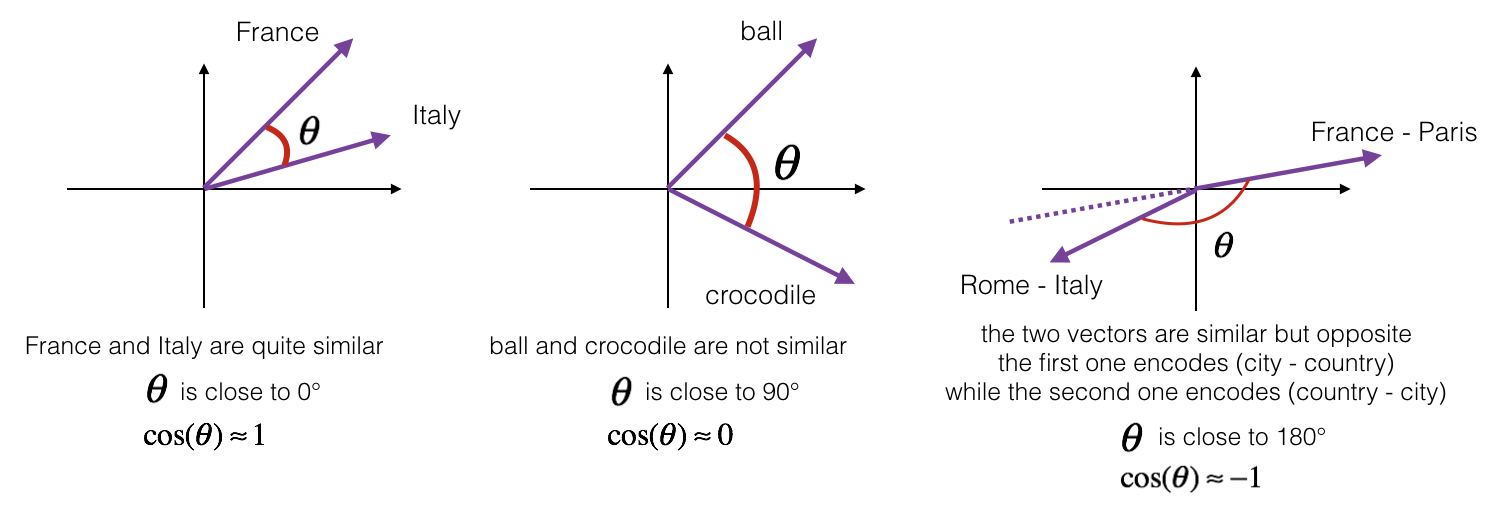

For instance, between the headline 5 and the first text we have a low similarity

In [17]:
print(cosine_similarity(document_vector(data['headlines'].iloc[5]).reshape(1, -1),vectors_of_texts[0].reshape(1, -1)))

[[0.28760344]]


On the other hand, between the headline 5 and the text 5 we have a high similarity

In [18]:
print(cosine_similarity(document_vector(data['headlines'].iloc[5]).reshape(1, -1),vectors_of_texts[5].reshape(1, -1)))

[[0.81752443]]


We can notice that cosine_similarity function (offered by scikitlearn) isn't very efficient, let's code a parallelized cosine similarity using numba and colab gpus. 

The parallelization in this project is highly important because we are dealing with very big vectors.

In [58]:
import numba

@numba.guvectorize(["void(float64[:], float64[:], float64[:])"], "(n),(n)->()", target='parallel')
def fast_cosine_gufunc(u, v, result):
    m = u.shape[0]
    udotv = 0
    u_norm = 0
    v_norm = 0
    for i in range(m):
        if (np.isnan(u[i])) or (np.isnan(v[i])):
            continue

        udotv += u[i] * v[i]
        u_norm += u[i] * u[i]
        v_norm += v[i] * v[i]

    u_norm = np.sqrt(u_norm)
    v_norm = np.sqrt(v_norm)

    if (u_norm == 0) or (v_norm == 0):
        ratio = 1.0
    else:
        ratio = udotv / (u_norm * v_norm)
    result[:] = ratio

print(fast_cosine_gufunc(document_vector(data['headlines'].iloc[5]).reshape(1, -1),vectors_of_texts[0].reshape(1, -1)))


[0.28760342]


### Let's consider a search query (a summarized text headline), we will have to compute the similarity of this query with all the texts of our data bases, then pick up the texts with **maximal score of similarity**

In [53]:
def cosine_sim(input_vector, vectors_of_texts):
  # This function outputs a vector of similarity bectween the input vector and all the vectors representing the texts of our data base
  matrix_sim = fast_cosine_gufunc(input_vector, vectors_of_texts)
  return(matrix_sim)


In [21]:
# For example, for the 5th headline we have the following vector of similarity
print(data['headlines'].iloc[5])
sim = cosine_sim(document_vector(data['headlines'].iloc[5]).reshape(1, -1), vectors_of_texts)

Rahat Fateh Ali Khan denies getting notice for smuggling currency


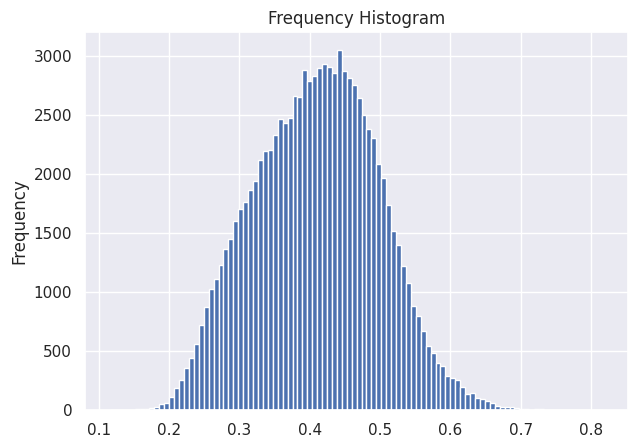

In [22]:
# Here we plot the distribution of the similarities of the 5th headlines with the texts in the database, we have few similar texts 
# a text is considered to be similar to the headline if the cosine similarity is hegher then 0.65
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
plt.hist(sim, bins=100)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

### The following function picks up the indices of the most similar texts to the input 

In [61]:
@numba.jit
def max_indices_k(sim,k):
  return np.argsort(sim)[-k:][::-1]


In [24]:
# for instance, for the 5th headline we have the following 3 most similar texts

data['text'].iloc[max_indices_k(sim, 3)].values

array(['Pakistani singer Rahat Fateh Ali Khan has denied receiving any notice from the Enforcement Directorate over allegedly smuggling foreign currency out of India. "It would have been better if the authorities would have served the notice first if any and then publicised this," reads a press release issued on behalf of Rahat. The statement further called the allegation "bizarre".',
       "Pakistani singer Rahat Fateh Ali Khan has been issued a show cause notice by the Enforcement Directorate (ED) for allegedly smuggling illegal foreign currency out of India for three years. Khan got $340,000 (â\x82¹2.42 crore) through illegal means, of which he reportedly smuggled $225,000 (â\x82¹1.6 crore). The ED has sought the singer's response within 45 days.",
       'Composer Shamir Tandon, while defending the use of Pakistani singer Rahat Fateh Ali Khan\'s voice in \'Welcome to New York\', questioned why Rahat\'s songs \'Jag Ghoomeya\' and \'Mere Rashke Qamar\' weren\'t removed from the film

In [25]:
# and the headline is:

data['headlines'].iloc[5]

'Rahat Fateh Ali Khan denies getting notice for smuggling currency'

### The following function is our model:
It takes as imputs:


1.   the input text (headline, or any other query)
2.   the number of recommendations we want

### The functions could be summarized as follows:


*   Embedding of the input text
*   Computation of cosine similarities with all the texts of our database
*   Identification of the most similar texts with their scores of similarity





In [67]:
def recommend(input_text, k):
  input_vector = document_vector(input_text).reshape(1, -1)
  
  matrix_sim = cosine_sim(input_vector, vectors_of_texts)
  sim = np.array(matrix_sim).reshape(1,-1)[0]
  #max_indices = sim.argsort()[-k:][::-1]
  max_indices = max_indices_k(sim, k)
  max_scores = sim[max_indices]
  similar_texts = data['text'].iloc[max_indices].values
  #d = dict(zip(similar_texts, max_scores))
  #df = pd.DataFrame(d.items(), columns=['text', 'score of similarity'])
  #return(df)
  return(similar_texts, max_scores)



### In order to text our model, we will pick up randomly 2000 headlines

In [68]:
test_samples = data.sample(n = 2000, random_state=1)


In [69]:
inputs = test_samples['headlines'].values

### One very important step is to choose the metric.

Our metric will be recall@k (as proposed in the test description):

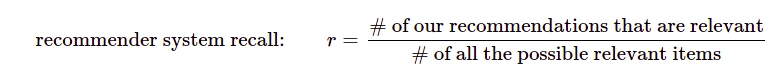

In our data set, We only have one possible relevant item. Therefore, the denominator of the recall@k is always = 1, and the numerator is <= 1.

#### To explain the meaning of the recall@k. Imagine taking your list of N recommendations and considering only the first element, then only the first two, then only the first three, etc... these subsets can be indexed by k. Precision and Recall at cutoff k, P(k) and r(k), are simply the precision and recall calculated by considering only the subset of your recommendations from rank 1 through k.
#### The higher k, the higher recall@k will be

In [70]:
def recommend30(input_text): return(recommend(input_text, 30)[0])

def recall_k(test_samples):
  inputs = test_samples['headlines'].values
  recommendations_30 = list(map(recommend30, inputs)) 
  recommendations_10 = [np.array(recommendation[0:10]) for recommendation in recommendations_30]
  recommendations_1 = [np.array(recommendation[0]) for recommendation in recommendations_30]
  dict_k = {}
  dict_k[1] = sum( x in y for x, y in zip(test_samples['text'].values, recommendations_1))/len(test_samples)
  dict_k[10] = sum( x in y for x, y in zip(test_samples['text'].values, recommendations_10))/len(test_samples)
  dict_k[30] = sum( x in y for x, y in zip(test_samples['text'].values, recommendations_30))/len(test_samples)
  df = pd.DataFrame(dict_k.items(), columns=['k', 'recall@k'])
  return(df)


In [71]:

recall_k(test_samples)

k  recall@k
0   1    0.5550
1  10    0.8105
2  30    0.8815

### We notice that the recall@k raises as k increases. with k=30 we havea 88% recall.

## **Embedding of texts with topic modeling (LDA)**
### In this part, let's proceed in a different way:


1.   We will first tokenize and clean data
2.   We will then train LDA to extract some latent features (semantic meanint). Basically, we will train a model that learn topics from our texts data, and assign a probability for each topic, for a given text.
3.   Using the latent features obtained thanks to LDA, we can build a vector transforming all of our texts into vectors of topic probabilities.
4.   For a given input (headline), we will have to transform the input into a topic probabilities vector, and compute its similarity with all of the vectors representing the texts database.
5.   Finally, the recommendations will be the texts with maximal similarities to the input.




In [36]:

ps =PorterStemmer()

lemmatizer = WordNetLemmatizer()

def tokenize_and_clean(text):
    doc = text
    doc = doc.lower()
    doc = word_tokenize(text)
    doc = [ps.stem(word) for word in doc if word not in stop_words]
    #we only keeps numeric and alphabetic caracters
    doc = [lemmatizer.lemmatize(word) for word in doc if word.isalpha() ] 
    return(doc)
texts = list(map(tokenize_and_clean, data['text'].values))


dictionary = corpora.Dictionary(texts)

corpus = [dictionary.doc2bow(text) for text in texts]



### We choose to extract 300 topic, the number of topics is a hyperparameter that should be optimized 

In [74]:

# Set training parameters.
num_topics = 300
chunksize = 2000
#passes = 20
#iterations = 1000
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

lda_model = models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    #iterations=iterations,
    num_topics=num_topics,
    #passes=passes,
    eval_every=eval_every
)


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [14]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 56037
Number of documents: 98401


In [102]:
top_topics = lda_model.top_topics(corpus) 

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

#pprint(top_topics)

Average topic coherence: -8.1753.


In [76]:
def document_to_lda_features(lda_model, document):
    """ Transforms a bag of words document to features.
    It returns the proportion of how much each topic was
    present in the document.
    """
    topic_importances = lda_model.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

### This function takes as an input a text, and gives its topic probabilities vector.

In [77]:
def lda_features_extraction(text):
  doc = tokenize_and_clean(text)
  doc = dictionary.doc2bow(doc)
  return(document_to_lda_features(lda_model, doc))
lda_features_extraction(data['text'].iloc[5])

array([1.50548105e-04, 1.67903825e-04, 1.21581237e-04, 1.17948715e-04,
       1.46701510e-04, 1.20994053e-04, 1.60599564e-04, 1.49467582e-04,
       2.02295574e-04, 1.04083178e-04, 1.29662483e-04, 1.29469918e-04,
       1.20293989e-04, 1.53186309e-04, 1.10920810e-04, 1.99661488e-04,
       1.24129190e-04, 1.51206652e-04, 2.83851810e-02, 1.31810797e-04,
       1.19676224e-04, 2.69356482e-02, 1.80778516e-04, 1.37728261e-04,
       1.22481186e-04, 1.11951951e-04, 1.16262243e-04, 2.04404554e-04,
       1.87406884e-04, 1.48725812e-04, 1.06332838e-04, 1.91285464e-04,
       2.24408868e-04, 2.16240747e-04, 1.38421747e-04, 1.49050495e-04,
       1.57745279e-04, 1.34043308e-04, 1.14540802e-04, 1.03841230e-04,
       1.26869345e-04, 2.69100405e-02, 1.57196788e-04, 1.21244360e-04,
       1.39029275e-04, 1.86664402e-04, 1.49322237e-04, 1.13921851e-04,
       1.55605114e-04, 1.30512708e-04, 1.61158154e-04, 1.14953793e-04,
       1.01195081e-04, 1.00260469e-04, 1.05903164e-04, 1.23763049e-04,
      

### Let's generate topics vectors for all our texts in the database

In [78]:
lda_vectors_text = list(map(lda_features_extraction, data['text'].values))

### Finally, we can use the previous results to recommend texts using cosine similarity between topics vectors

In [79]:
def recommend_with_LDA(input_text, k):
  input_vector = lda_features_extraction(input_text).reshape(1, -1)
  
  matrix_sim = cosine_sim(input_vector, lda_vectors_text)
  sim = np.array(matrix_sim).reshape(1,-1)[0]
  #max_indices = sim.argsort()[-k:][::-1]
  max_indices = max_indices_k(sim, k)
  max_scores = sim[max_indices]
  similar_texts = data['text'].iloc[max_indices].values
  #d = dict(zip(similar_texts, max_scores))
  #df = pd.DataFrame(d.items(), columns=['text', 'score of similarity'])
  #return(df)
  return(similar_texts, max_scores)


In [80]:
#example
recommend_with_LDA(data['headlines'].iloc[5],3)

(array(['Pakistani singer Rahat Fateh Ali Khan has denied receiving any notice from the Enforcement Directorate over allegedly smuggling foreign currency out of India. "It would have been better if the authorities would have served the notice first if any and then publicised this," reads a press release issued on behalf of Rahat. The statement further called the allegation "bizarre".',
        "Pakistani singer Rahat Fateh Ali Khan has been issued a show cause notice by the Enforcement Directorate (ED) for allegedly smuggling illegal foreign currency out of India for three years. Khan got $340,000 (â\x82¹2.42 crore) through illegal means, of which he reportedly smuggled $225,000 (â\x82¹1.6 crore). The ED has sought the singer's response within 45 days.",
        'American retail chain Walmart has paid â\x82¹7,439 crore in tax to the government on payments made to buy shares of 10 major Flipkart shareholders. However, Walmart has not yet paid tax on buyout of shares of 34 other sharehol

In [81]:
def recommend30_LDA(input_text): return(recommend_with_LDA(input_text, 30)[0])

# This function measures the performance of the model (with LDA)
def recall_k_LDA(test_samples):
  inputs = test_samples['headlines'].values
  recommendations_30 = list(map(recommend30_LDA, inputs)) 
  recommendations_10 = [np.array(recommendation[0:10]) for recommendation in recommendations_30]
  recommendations_1 = [np.array(recommendation[0]) for recommendation in recommendations_30]
  dict_k = {}
  dict_k[1] = sum( x in y for x, y in zip(test_samples['text'].values, recommendations_1))/len(test_samples)
  dict_k[10] = sum( x in y for x, y in zip(test_samples['text'].values, recommendations_10))/len(test_samples)
  dict_k[30] = sum( x in y for x, y in zip(test_samples['text'].values, recommendations_30))/len(test_samples)
  df = pd.DataFrame(dict_k.items(), columns=['k', 'recall@k'])
  return(df)


In [82]:
recall_k_LDA(test_samples)

k  recall@k
0   1     0.197
1  10     0.418
2  30     0.538

### We conclude that the first model is better in terms of performance: we had a recall@k of 88% with k=30, while with LDA we have 53%.

### Thus, using word2vec is better for the embedding, than using bag of words + LDA. 
### I wanted to try LDA in order to extract semantic meaning in a better way, but I believe that even word2vec does it well.

## **Does our model deal with short texts instead of complete summarized text headlines?**

### I believe that our first model does perform well on short texts, since the main idea of it is to embed inputs, no matter what is the length of these inputs. 
### The other reason explaining this is that cosine similarity deals very well with sparse vectors, and thus with short texts.

In [83]:
human_rights_texts = recommend('human rights', 30)

In [86]:
# The recommendations we get when the input is "human rights"
human_rights_texts[0]

array(['The Union Cabinet on Wednesday approved the Protection of Human Rights (Amendments) Bill, 2018 for better protection and promotion of human rights in India. An official statement said the amended act would be in sync with agreed global standards and benchmarks towards ensuring rights relating to life, liberty, equality, and dignity of the individual in the country.',
       'The Universal Declaration of Human Rights was adopted by the UN General Assembly on December 10, 1948. The document is based on the principles of dignity, equality, and fairness, and sets out a range of rights and freedoms to which every human being is entitled. It is the most translated document in the world, available in more than 500 languages.',
       'Rejecting US\' allegations of human rights violations as an attempt to topple the regime, North Korea has called itself a "utopia envied by humankind" and a "flower garden of human love". "US pressure over human rights is equivalent to an act of politica

## **Does our model deal with unknown words?**

### Since the vocabulary contained in the training of word2vec is very large, we don"t have to worry about whether the input might be a new word.
### Furthermore, word2vec is available to learn similarity between any word of the input and the texts database. 

## **Other possible evaluation criterias**:
### Precision@k: But this criteria would be irrelevant, because we don't have enough relevant items to evaluate our models on (we only assign one relevant text to every headline)
### Average recall or average precision:
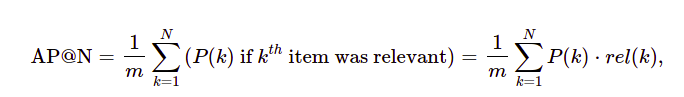

where rel(k) is just an indicator that says whether that kth item was relevant (rel(k)=1) or not (rel(k)=0).

## **What next steps to improve the performance?**

### We can try to work on the embedding, and find a way to extract relevant semantic meaning. One way to do that is to use Bert embedding.

### Using an attention embedding would improve the understanding of the semantic characteristics rather than use overlapping words for instance.